# Query Length Evaluation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pyterrier as pt
import seaborn as sns

from pathlib import Path
from scipy.stats import pearsonr
from trectools import TrecRun, TrecEval, TrecQrel, TrecTopics
from tqdm import tqdm


pt.init()

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [2]:
def read_topics(filename):
    topics = TrecTopics()
    topics.read_topics_from_file(filename, topic_tag='top', querytext_tag='title',
                                 numberid_tag='num', number_attr=False)

    return topics


data_dir = Path('~/Data/LongEval').expanduser()


months = {
    'WT': 'June',
    'ST': 'July',
    'LT': 'Sept.',
}

qrels = {
    'WT': TrecQrel(data_dir / 'longeval-relevance-judgements/heldout-test.txt'),
    'ST': TrecQrel(data_dir / 'longeval-relevance-judgements/a-short-july.txt'),
    'LT': TrecQrel(data_dir / 'longeval-relevance-judgements/b-long-september.txt'),
}

topics = {
    'WT': read_topics(data_dir / 'publish/English/Queries/heldout.trec'),
    'ST': read_topics(data_dir / 'test-collection/A-Short-July/English/Queries/test07.trec'),
    'LT': read_topics(data_dir / 'test-collection/B-Long-September/English/Queries/test09.trec'),
}

systems = [
    'bm25',
#     'bm25-5-variants-prompt-2',
#     'bm25-10-variants-prompt-2',
    'lgd-10-variants-prompt-2',
    'pl2-5-variants-prompt-2',
    'pl2-10-variants-prompt-2',
]

In [3]:
tokenizer = pt.rewrite.tokenise()

def evaluate_run(system: str, suffix: str):
    run = TrecRun(data_dir / f'runs/ows-{system}.{suffix}')
    qrel = qrels[suffix]

    te = TrecEval(run, qrel)

    ndcg = te.get_ndcg(depth=10, removeUnjudged=False, per_query=True).rename(columns={'NDCG@10': 'nDCG@10'})
    cond_ndcg = te.get_ndcg(depth=10, removeUnjudged=True, per_query=True).rename(columns={'NDCG@10': 'Cond. nDCG@10'})

    scores = ndcg.join(cond_ndcg).fillna(0).reset_index()

    scores['System'] = system
    scores['Month'] = months[suffix]

    scores['query_id'] = scores['query']
    scores['query'] = scores['query_id'].map(topics[suffix].topics.get)
    scores['Query Length'] = tokenizer.transform(scores)['query'].map(lambda q: len(q. split()))

    return scores

In [4]:
results = pd.concat([
    evaluate_run(system, suffix)
    for suffix in tqdm(months)
    for system in systems
])

results

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.90s/it]


,query,nDCG@10,Cond. nDCG@10,System,Month,query_id,Query Length
0,from heaven to dusky monic earth,0.000000,0.000000,bm25,June,q062210272,6
1,test car,0.000000,0.530721,bm25,June,q062210516,2
2,emeraude space,0.164837,0.677599,bm25,June,q06221083,2
3,the mad history of space,0.000000,0.000000,bm25,June,q062210941,5
4,The Legacy Office,0.000000,0.000000,bm25,June,q062210990,3
...,...,...,...,...,...,...,...
882,tax bracket 2019,0.000000,0.333333,pl2-10-variants-prompt-2,Sept.,q09229807,3
883,tucoenergie,0.411579,0.511592,pl2-10-variants-prompt-2,Sept.,q09229830,1
884,Veal's head,0.339160,0.598282,pl2-10-variants-prompt-2,Sept.,q09229846,3
885,value of totalenergies,0.000000,0.000000,pl2-10-variants-prompt-2,Sept.,q09229869,3


# Distribution of query lengths

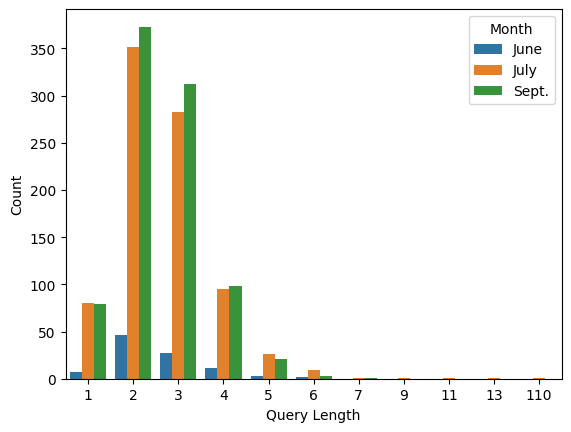

In [5]:
query_length_counts = results[results['System'] == 'bm25'].groupby(['Month', 'Query Length'])['query'].count()
query_length_counts = query_length_counts.rename('Count').reset_index()

bar = sns.barplot(query_length_counts, x='Query Length', y='Count', hue='Month', hue_order=list(months.values()))
sns.move_legend(bar, 'upper right')
# bar.set_title('Query lengths for the LongEval test sets')

plt.savefig('query-length-distribution.pdf')

# Performance for different query lengths

In [6]:
scores_per_query_length = results.groupby(['Month', 'System', 'Query Length'])[['nDCG@10', 'Cond. nDCG@10']].mean().reset_index()
scores_per_query_length = scores_per_query_length[scores_per_query_length['Query Length'] < 7]

scores_per_query_length

,Month,System,Query Length,nDCG@10,Cond. nDCG@10
0,July,bm25,1,0.125414,0.367476
1,July,bm25,2,0.189821,0.484856
2,July,bm25,3,0.199210,0.531193
3,July,bm25,4,0.180368,0.493976
4,July,bm25,5,0.199419,0.546277
...,...,...,...,...,...
90,Sept.,pl2-5-variants-prompt-2,2,0.179508,0.494416
91,Sept.,pl2-5-variants-prompt-2,3,0.176573,0.526382
92,Sept.,pl2-5-variants-prompt-2,4,0.159639,0.531715
93,Sept.,pl2-5-variants-prompt-2,5,0.205176,0.571528


## nDCG@10

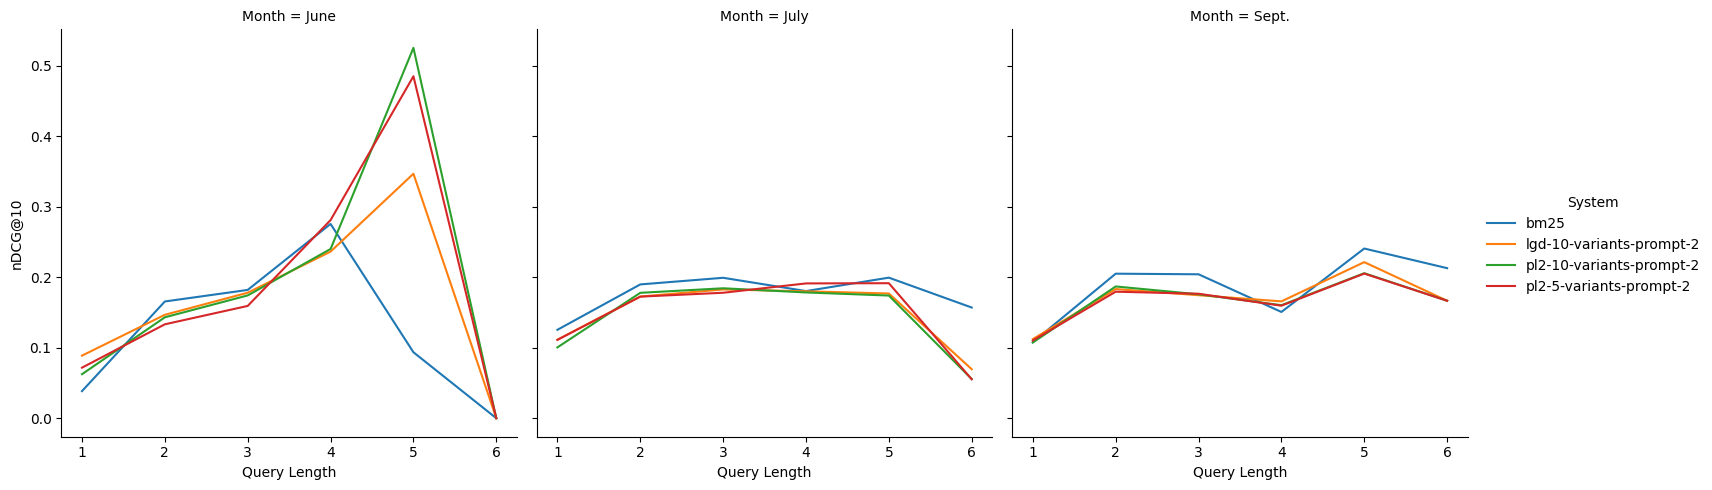

In [7]:
rel = sns.relplot(scores_per_query_length, x='Query Length', y='nDCG@10', kind='line', hue='System',
                  col='Month', col_order=list(months.values()))

# rel.fig.subplots_adjust(top=.8)
# rel.fig.suptitle('nDCG@10 for different query lengths')

plt.savefig('query-length-vs-ndcg.pdf')

## Condensed nDCG@10

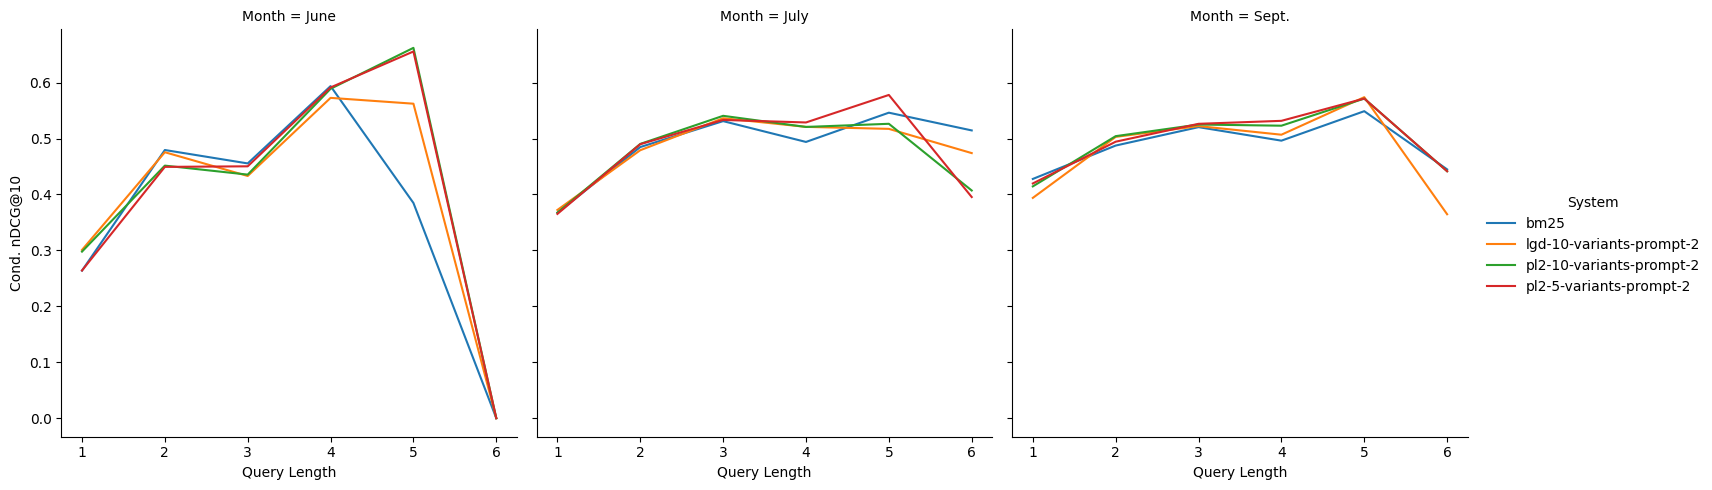

In [8]:
rel = sns.relplot(scores_per_query_length, x='Query Length', y='Cond. nDCG@10', kind='line', hue='System',
                  col='Month', col_order=list(months.values()))

# rel.fig.subplots_adjust(top=.8)
# rel.fig.suptitle('Cond. nDCG@10 for different query lengths')

plt.savefig('query-length-vs-cond-ndcg.pdf')

In [9]:
for month in months.values():
    for metric in ['nDCG@10', 'Cond. nDCG@10']:
        df = results[results['Month'] == month].sort_values(['System', 'query_id'])
        a = df[df['System'] == 'bm25']
        b = df[df['System'] == 'pl2-10-variants-prompt-2']

        diff = a[metric] - b[metric]
        length = a['Query Length']

        print(f'{month:<5} {metric:>13} {pearsonr(diff, length)}')

June        nDCG@10 PearsonRResult(statistic=-0.1793749662205246, pvalue=0.08034306211996207)
June  Cond. nDCG@10 PearsonRResult(statistic=-0.11927469667023786, pvalue=0.24707742229493537)
July        nDCG@10 PearsonRResult(statistic=-0.0003311434600134049, pvalue=0.9923083516601345)
July  Cond. nDCG@10 PearsonRResult(statistic=0.04737203867528546, pvalue=0.16762892834464146)
Sept.       nDCG@10 PearsonRResult(statistic=0.005759381799444062, pvalue=0.8639968547234151)
Sept. Cond. nDCG@10 PearsonRResult(statistic=-0.025222516994366583, pvalue=0.4531036620368135)
